### Cleaning and converting all 3 files to the csv files

In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load raw dataset
df = pd.read_csv("student-mat.csv", sep=';')

# 1. Creating binary target variable (Pass/Fail)
df["Pass"] = (df["G3"] >= 10).astype(int)

# 2. Select features relevant to academic performance
selected_cols = [
    "studytime",     # weekly study time (1 to 4)
    "failures",      # number of past class failures
    "goout",         # going out with friends (1 to 5)
    "famsup",        # family support (yes/no)
    "higher",        # wants higher education (yes/no)
    "Dalc",          # workday alcohol consumption (1 to 5)
    "absences",      # number of absences
    "Pass"           # target variable
]
df = df[selected_cols]

# 3. Encoding categorical values
label_cols = ["famsup", "higher"]
for col in label_cols:
    df[col] = LabelEncoder().fit_transform(df[col])  # yes 1, no 0

# 4. Saving the cleaned data
df.to_csv("ltn_student_data.csv", index=False, sep = ',')

print("Saved dataset shape:", df.shape)


Saved dataset shape: (395, 8)


In [99]:
df = pd.read_csv('ltn_student_data.csv')
df.head()

,studytime,failures,goout,famsup,higher,Dalc,absences,Pass
0,2,0,4,0,1,1,6,0
1,2,0,3,1,1,1,4,0
2,2,3,2,0,1,2,10,1
3,3,0,2,1,1,1,2,1
4,2,0,2,1,1,1,4,1


In [ ]:
!pip install LTNtorch

In [2]:
from ltn.core import Variable, Predicate, Constant, Function, Connective, diag, undiag, Quantifier, \
    LTNObject, process_ltn_objects, LambdaModel
import torch
import ltn.fuzzy_ops

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# 1. Importing the necessary libs

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import ltn
from ltn import Variable, Predicate, LTNObject
import ltn.fuzzy_ops as fuzzy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 2. Loading and normalizing data

df = pd.read_csv("ltn_student_data.csv")
X = df.drop(columns=["Pass"]).values
y = df["Pass"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)


failures = df["failures"].values  # extracting failures column to put for splitting

# Splitting all arrays
X_train, X_test, y_train, y_test, failures_train, failures_test = train_test_split(
    X, y, failures, test_size=0.2, random_state=42)

# Converting them into tensors...

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

failures_tensor = torch.tensor(failures_train, dtype=torch.float32)
failures_train_tensor = torch.tensor(failures_train, dtype=torch.float32)
failures_tensor_test = torch.tensor(failures_test, dtype=torch.float32)



# 3. Defining LTN Variables

students = Variable("x", X_train)
labels = Variable("y", y_train)

# 4. Defining the neural predicates

n_features = X.shape[1]


# creating a simple NN model for predicates

def make_predicate():
    return Predicate(nn.Sequential(
        nn.Linear(n_features, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(32, 1),
        nn.Sigmoid()
    ))


Pass = make_predicate()

HighStudyTime = make_predicate()
LowAbsences = make_predicate()

# 5. giving the logical rules

def fuzzy_implies(a, b):
    a_val = a.value if hasattr(a, 'value') else a
    b_val = b.value if hasattr(b, 'value') else b
    return torch.maximum(1.0 - a_val, b_val)



# Rule 1: supervised supervision for ground truth

pred_output = Pass(students)
truth_val_tensor = 1.0 - torch.abs(pred_output.value - labels.value)

# Agg. the truth values across the batch to get a scalar
truth_val_scalar = truth_val_tensor.mean()
truth_val_ltn = LTNObject(value=truth_val_scalar, var_labels=[])

# Rule 2: if study time is high => student passes
rule1_tensor = fuzzy_implies(HighStudyTime(students), Pass(students))

# Agg. the truth values across the batch to get a scalar
rule1_scalar = rule1_tensor.mean()
rule1 = LTNObject(value=rule1_scalar, var_labels=[])

# Rule 3: if absences are low => student passes
rule2_tensor = fuzzy_implies(LowAbsences(students), Pass(students))

# Agg. the truth values across the batch to get a scalar
rule2_scalar = rule2_tensor.mean()
rule2 = LTNObject(value=rule2_scalar, var_labels=[])


# Rule 4: If student has few failures => more likely to pass
def fuzzy_less_than(x, threshold):
    return 1.0 - torch.sigmoid(x - threshold)

failures_tensor = torch.tensor(df["failures"].values, dtype=torch.float32)
LowFailures = Variable("failures", failures_tensor)


rule3_tensor = fuzzy_implies(fuzzy_less_than(failures_train_tensor, 2), Pass(students))

rule3_scalar = rule3_tensor.mean()
rule3 = LTNObject(value=rule3_scalar, var_labels=[])



# 6. creating the optimizer and aggregator

aggregator = fuzzy.SatAgg()

w1, w2, w3 = 0.9, 0.9, 0.2  #  best weights for the rules (found them by tuning manually()

# weighted rule values

rule1_weighted = LTNObject(value= w1 * rule1.value, var_labels=[])
rule2_weighted = LTNObject(value= w2 * rule2.value, var_labels=[])
rule3_weighted = LTNObject(value= w3 * rule3.value, var_labels=[])

# used to creat a good aggregator

sat = aggregator(
    truth_val_ltn,
    rule1_weighted,
    rule2_weighted,
    rule3_weighted
)


optimizer = optim.Adam(
    list(Pass.parameters()) +
    list(HighStudyTime.parameters()) +
    list(LowAbsences.parameters()),
    lr=0.001                        # best learning rate (I found it by manual tuning)
)

sat_levels = []
bce_losses = []


# 7. here I trained with hybrid loss (logic + label supervision)

for epoch in range(200):
    optimizer.zero_grad()

    # ////////////////// Ground Truth Supervision \\\\\\\\\\\\\\\\\\\\

    pred_output = Pass(students).value

    # Binary Cross-Entropy loss
    bce_loss = nn.BCELoss()(pred_output, y_train.squeeze(1))


    # Rule: predicted values should be close to ground-truth
    truth_val_tensor = 1.0 - torch.abs(pred_output - y_train)
    truth_val_scalar = truth_val_tensor.mean()
    truth_val_ltn = LTNObject(value=truth_val_scalar, var_labels=[])

    # ---------- Rule 1: If study time high => pass ----------
    rule1_tensor = fuzzy_implies(HighStudyTime(students), Pass(students))
    rule1_scalar = rule1_tensor.mean()
    rule1 = LTNObject(value=rule1_scalar, var_labels=[])

    # ---------- Rule 2: If absences low => pass ----------
    rule2_tensor = fuzzy_implies(LowAbsences(students), Pass(students))
    rule2_scalar = rule2_tensor.mean()
    rule2 = LTNObject(value=rule2_scalar, var_labels=[])

    # ---------- Rule 3: If failures < 2 => pass ----------
    failures_tensor = torch.tensor(df["failures"].values, dtype=torch.float32)
    def fuzzy_less_than(x, threshold):
        return 1.0 - torch.sigmoid(x - threshold)

    rule3_tensor = fuzzy_implies(fuzzy_less_than(failures_train_tensor, 2), Pass(students))


    rule3_scalar = rule3_tensor.mean()
    rule3 = LTNObject(value=rule3_scalar, var_labels=[])

    # ---------- Final Loss ----------
    sat_loss = 1.0 - aggregator(truth_val_ltn, rule1, rule2, rule3)
    loss = sat_loss + 0.05 * bce_loss       # best parameter for the loss (0.05) (I found it by manual tuning  : 0.05, 0.5, 1, 1.5)

    loss.backward()
    optimizer.step()


    if epoch % 20 == 0:
      sat_value = 1.0 - sat_loss.item()
      bce_value = bce_loss.item()

      sat_levels.append(sat_value)
      bce_losses.append(bce_value)

      print(f"Epoch {epoch}: Sat Level = {sat_value:.4f} | BCE Loss = {bce_value:.4f}")




# 8. Evaluation
with torch.no_grad():
    test_var = Variable("x", X_test)
    predictions = Pass(test_var).value
    y_pred = (predictions >= 0.5).float()
    accuracy = (y_pred == y_test).float().mean()
    print(f"\nTest Accuracy: {accuracy.item() * 100:.2f}%")

Epoch 0: Sat Level = 0.5416 | BCE Loss = 0.6876
Epoch 20: Sat Level = 0.6391 | BCE Loss = 0.6076
Epoch 40: Sat Level = 0.6924 | BCE Loss = 0.5915
Epoch 60: Sat Level = 0.7279 | BCE Loss = 0.5999
Epoch 80: Sat Level = 0.7510 | BCE Loss = 0.6184
Epoch 100: Sat Level = 0.7694 | BCE Loss = 0.6396
Epoch 120: Sat Level = 0.7837 | BCE Loss = 0.6671
Epoch 140: Sat Level = 0.7955 | BCE Loss = 0.7222
Epoch 160: Sat Level = 0.8030 | BCE Loss = 0.7256
Epoch 180: Sat Level = 0.8091 | BCE Loss = 0.7909

Test Accuracy: 65.82%


In [7]:
with torch.no_grad():
    # Ground-truth satisfaction (label agreement)
    pred_output = Pass(students).value
    sat_truth_val = (1.0 - torch.abs(pred_output - y_train)).mean().item()

    # Rule 1: High Study Time => Pass
    sat_rule1 = fuzzy_implies(HighStudyTime(students), Pass(students)).mean().item()

    # Rule 2: Low Absences => Pass
    sat_rule2 = fuzzy_implies(LowAbsences(students), Pass(students)).mean().item()

    # Rule 3: Failures < 2 => Pass
    sat_rule3 = fuzzy_implies(fuzzy_less_than(failures_train_tensor, 2), Pass(students)).mean().item()

    # Converting scalars to tensors before wrapping them into ltn objects

    rule1_obj = LTNObject(value=torch.tensor(sat_rule1), var_labels=[])
    rule2_obj = LTNObject(value=torch.tensor(sat_rule2), var_labels=[])
    rule3_obj = LTNObject(value=torch.tensor(sat_rule3), var_labels=[])
    truth_obj = LTNObject(value=torch.tensor(sat_truth_val), var_labels=[])

    # Overall satisfaction using aggregator

    overall_sat = aggregator(truth_obj, rule1_obj, rule2_obj, rule3_obj).item()

    # Print the results
    print("=== Final Satisfaction Levels ===")
    print(f"SAT Truth Value (Label Agreement): {sat_truth_val:.4f}")
    print(f"SAT Rule 1 (Study Time → Pass):     {sat_rule1:.4f}")
    print(f"SAT Rule 2 (Low Absences → Pass):   {sat_rule2:.4f}")
    print(f"SAT Rule 3 (Failures < 2 → Pass):   {sat_rule3:.4f}")
    print(f"Overall Aggregated SAT:             {overall_sat:.4f}")



=== Final Satisfaction Levels ===
SAT Truth Value (Label Agreement): 0.6432
SAT Rule 1 (Study Time → Pass):     0.9556
SAT Rule 2 (Low Absences → Pass):   0.9487
SAT Rule 3 (Failures < 2 → Pass):   0.9146
Overall Aggregated SAT:             0.8134


## -----------> VISUALIZATIONS <-------------

### Training Metrics over Epochs (Sat Level & BCE Loss)

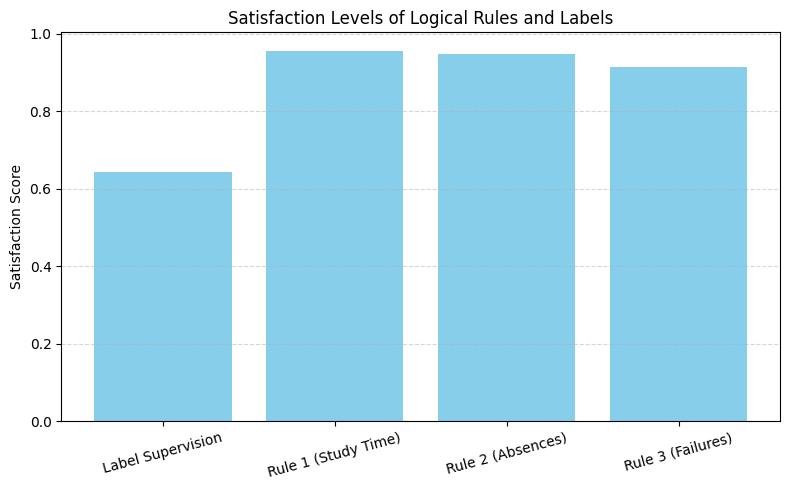

In [10]:
import matplotlib.pyplot as plt
import numpy as np


# 1. Rule Satisfaction Levels

plt.figure(figsize=(8, 5))
components = ['Label Supervision', 'Rule 1 (Study Time)', 'Rule 2 (Absences)', 'Rule 3 (Failures)']
values = [sat_truth_val, sat_rule1, sat_rule2, sat_rule3]
plt.bar(components, values, color='skyblue')
plt.title('Satisfaction Levels of Logical Rules and Labels')
plt.ylabel('Satisfaction Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

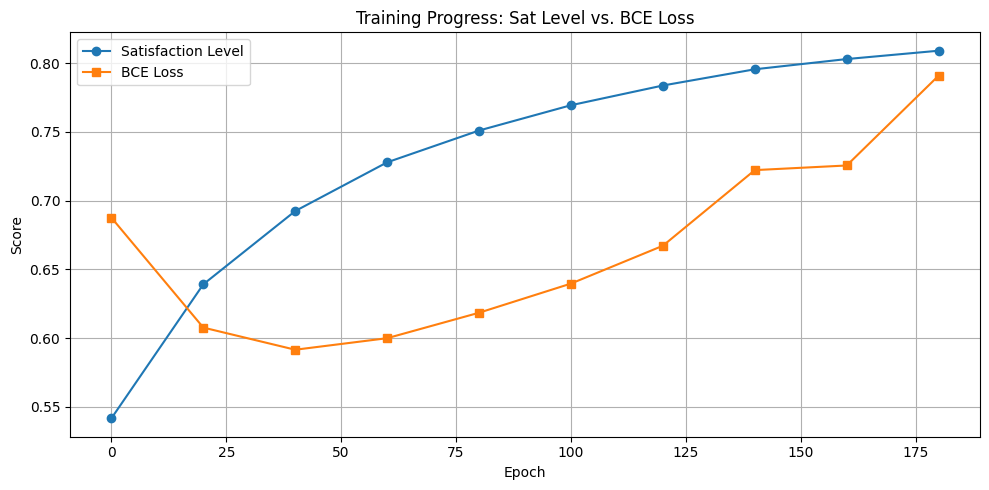

In [12]:
import matplotlib.pyplot as plt


epochs = list(range(0, 200, 20))
# sat_levels = [0.4891, 0.5813, 0.6441, 0.6921, 0.7261, 0.7551, 0.7771, 0.7923, 0.8021, 0.8069]
# bce_losses = [0.7448, 0.6721, 0.6369, 0.6314, 0.6549, 0.6413, 0.6815, 0.7115, 0.7835, 0.7793]

plt.figure(figsize=(10, 5))
plt.plot(epochs, sat_levels, label='Satisfaction Level', marker='o')
plt.plot(epochs, bce_losses, label='BCE Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Training Progress: Sat Level vs. BCE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Prediction Distribution on Test Set

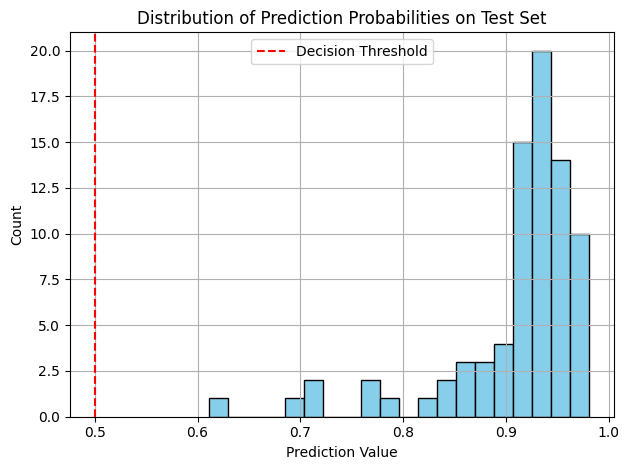

In [13]:
with torch.no_grad():
    preds = Pass(Variable("x", X_test)).value
    plt.hist(preds.numpy(), bins=20, color='skyblue', edgecolor='black')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
    plt.title("Distribution of Prediction Probabilities on Test Set")
    plt.xlabel("Prediction Value")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Confusion Matrix

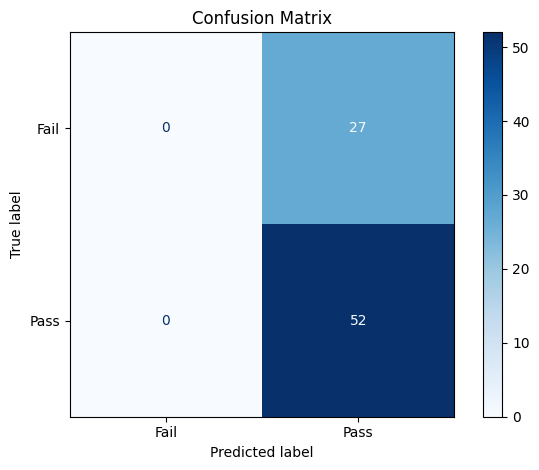

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Threshold predictions

y_pred = (preds >= 0.5).float()
cm = confusion_matrix(y_test.numpy(), y_pred.numpy())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fail", "Pass"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


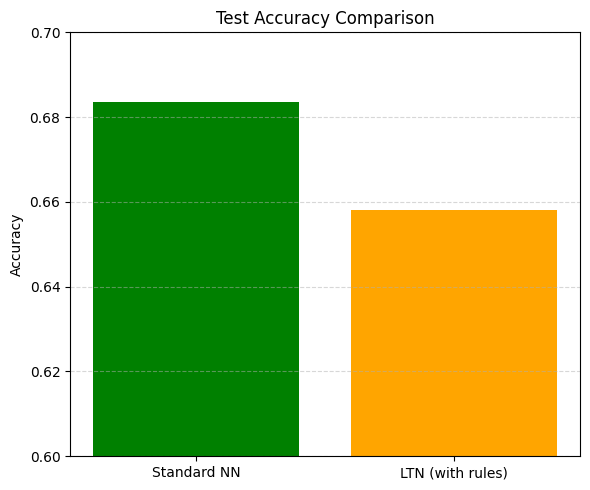

In [15]:
# Accuracy Comparison of std NN vs LTN with rules...

plt.figure(figsize=(6, 5))
methods = ['Standard NN', 'LTN (with rules)']
accuracies = [0.6835, 0.6582]  # Standard NN is computed previously and it displays 0.6835 accuracy
plt.bar(methods, accuracies, color=['green', 'orange'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.6, 0.7)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


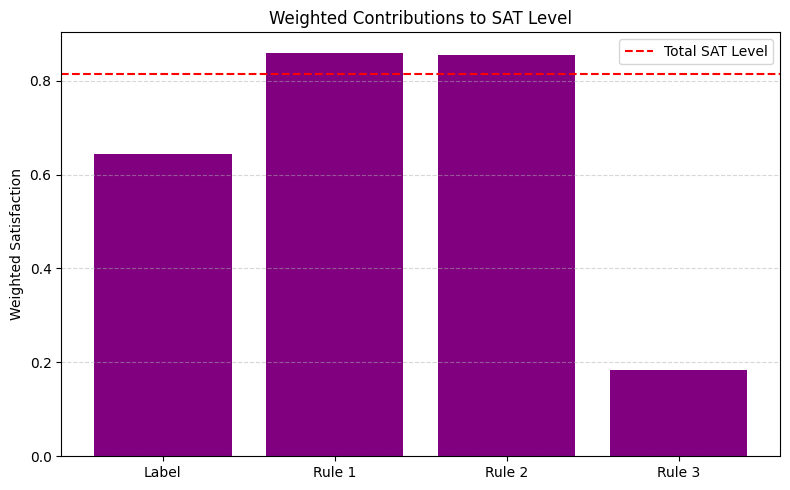

In [16]:
# Weighted Contributions to SAT

plt.figure(figsize=(8, 5))
components = ['Label', 'Rule 1', 'Rule 2', 'Rule 3']
contributions = [
    sat_truth_val,
    w1 * sat_rule1,
    w2 * sat_rule2,
    w3 * sat_rule3
]
plt.bar(components, contributions, color='purple')
plt.axhline(y=overall_sat, color='red', linestyle='--', label='Total SAT Level')
plt.title('Weighted Contributions to SAT Level')
plt.ylabel('Weighted Satisfaction')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()